# Neural Kalman Filters

This notebook demonstrates the training and testing of a ***Neural Kalman Filter*** (NKF) on simulated data of Radar detections. Other variants are the *predicted-acceleration KF* (aKF) and the *NKF with H-prediction* (NKFH).

The following modules were implemented for aKF, NKF and NKFH (note that some are deprecated as mentioned below):
- Acceleration prediction - in aKF, NKF, NKFH
- $Q$ prediction (with diagonal constraint) - in NKF, NKFH
- $R$ prediction (with diagonal constraint) - in NKF, NKFH
- Observation model ($H$) prediction (somewhat unstable) - in NKFH
- Mixture-of-Gaussians representation - deprecated (unstable and no significant improvement)

The NKF achieved significant improvement over the standard KF.
However, as shown below, by changing the baseline from a standard KF (with estimated parameters) to an ***Optimized KF*** (OKF, with optimized parameters), NKF has no added value anymore.
In other words, it seems that the NKF (as implemented in this work, at least) does not provide beneficial expressiveness for the problem, but only enjoys the optimization itself - which can be obtained with far less trouble.

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle as pkl
from collections import Counter
import gc

import torch
import torch.nn.functional as F

import utils
import TargetSimulator as Sim
import SensorGenerator as Rad
import Trackers
import NeuralTrackers as NT
import TrackingLab as TLAB
import PredictionLab as PLAB

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Generate data

In [3]:
ID = 0

### Set configuration

In [4]:
def get_scenario(max_acc=0, n_episodes=1000, n_targets=1, n_turns=3, p_vertical=0.3, seed_base=0,
                 old_mode=True, noise=1, far=0, title=None, train=False):
    if title is None:
        title = 'train' if train else 'test'
    seeds = seed_base + np.arange(n_episodes)
    
    return dict(
        targets = dict(
            n_episodes = n_episodes,
            dt = 1,
            old_mode = old_mode,
            acc = max_acc,
            n_targets_args = dict(n1=n_targets-3, n2=n_targets+4) if n_targets>3 else n_targets,
            init_args=dict(t0=10, dt=3, X0=(0,0,0), dx=(4e3,4e3,4e2), V0=(50,0,90), dV=(15,10000,6),
                           unif_x=True, unif_v=False), # dx=(2e3,2e3,1e2)
            n_turns_args = dict(n1=n_turns-1, n2=n_turns+2) if n_turns>1 else n_turns,
            line_args = dict(p_acc=0.5, t_mean=12, t_sigma=3, t_mean_acc=6, t_sigma_acc=2, vmax0=150),
            turn_args = dict(p_vertical=p_vertical, p_left=0.5, a_mean=45, a_sigma=270, vertical_fac=0.1),
            seeds = seeds,
            title = title,
        ),
        radar = dict(
            noise_factor = noise,
            FAR = 0,
        )
    )

In [5]:
title = f'benchmark{ID:02d}'
p_vertical = 0.12
a_test = (24,48,96) # (24,48,96)
a_train = (48,)
test_episodes = 100 # 100
train_episodes = 4000 # 4000
n_turns = 3
noise = 1
scenarios  = [get_scenario(a_train, n_episodes=train_episodes, n_targets=1, n_turns=n_turns,
                           p_vertical=p_vertical, noise=noise, seed_base=0, train=True)]
scenarios += [get_scenario(a_test, n_episodes=test_episodes, n_targets=20, n_turns=n_turns,
                           p_vertical=p_vertical, noise=noise, seed_base=train_episodes)]
scenarios  = {sc['targets']['title']:sc for sc in scenarios}

scenarios.keys()

dict_keys(['train', 'test'])

### Generate

(set `GENERATE=False` to load, `True` to generate)

4000 4000 (56, 4) (56, 6) 19.0 240.0 Counter({'24<acc<48': 4000})
CPU times: user 20.4 s, sys: 564 ms, total: 21 s
Wall time: 20.5 s


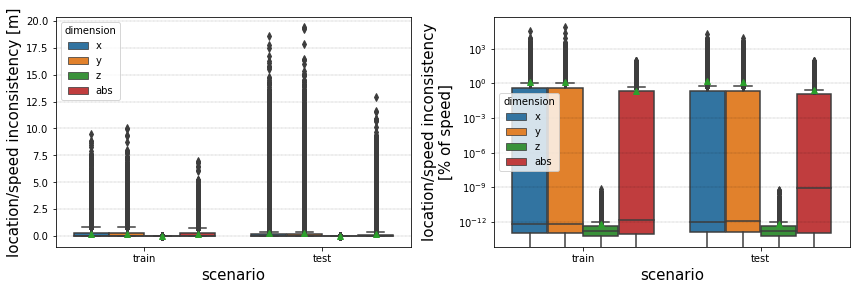

In [6]:
%%time
GENERATE = False
if GENERATE:
    # Generate data
    E = PLAB.create_experiment(scenarios=scenarios, title=title, load=False)
    E.meta_episodes.loc[E.meta_episodes.seed>=(train_episodes), 'group'] = 1
    E.meta_targets.loc[E.meta_targets.seed_ep>=(train_episodes), 'group'] = 1
    E.save_data()
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    PLAB.save_data(X, Y, scenarios_train, fname=f'train{ID:02d}')
    PLAB.save_data(X2, Y2, scenarios_test, fname=f'test{ID:02d}')
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

else:
    # just load
    E = PLAB.create_experiment(title=title, load=True)
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

dd = E.targets_consistency_test()

### Load

In [7]:
X,Y,scenarios_train = PLAB.load_data(fname=f'train{ID:02d}')
X2,Y2,scenarios_test = PLAB.load_data(fname=f'test{ID:02d}')

#### Sample target

In [8]:
story, info = E.get_target_story()
print(info)
story

{'max_acc': 96, 'time': 36.0}


phase      mode  time        acc   direct       angle
0      0  straight     6  75.042747  forward    0.000000
1      1      turn     4  16.094150     down  -20.581769
2      2  straight     6  59.927732  forward    0.000000
3      3      turn     8  49.299850     left -136.521071
4      4  straight     6  80.937744  forward    0.000000
5      5      turn     3  85.172373     left  -90.698091
6      6  straight     4  83.739090  forward    0.000000

#### Trajectories lengths

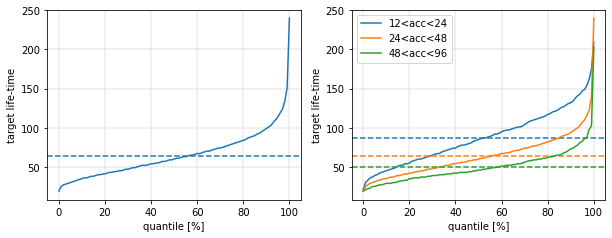

In [9]:
axs = utils.Axes(2)

utils.plot_quantiles(E.meta_targets['T'], plot_mean=True, ax=axs[0])
axs[0].set_xlabel('quantile [%]')
axs[0].set_ylabel('target life-time');

for cls in np.unique(E.meta_targets.target_class):
    utils.plot_quantiles(E.meta_targets[E.meta_targets.target_class==cls]['T'], plot_mean=True, label=cls, ax=axs[1])
axs[1].legend()
axs[1].set_xlabel('quantile [%]')
axs[1].set_ylabel('target life-time');

Text(0, 0.5, 'total time steps in data')

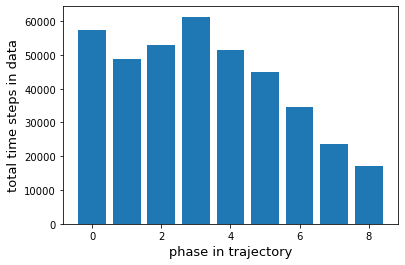

In [11]:
tmp = Counter(pd.concat([tar for sc in E.scenarios for ep in E.targets[sc] for tar in ep]).phase)
plt.bar(tmp.keys(), tmp.values())
plt.xlabel('phase in trajectory', fontsize=13)
plt.ylabel('total time steps in data', fontsize=13)

#### Sample targets

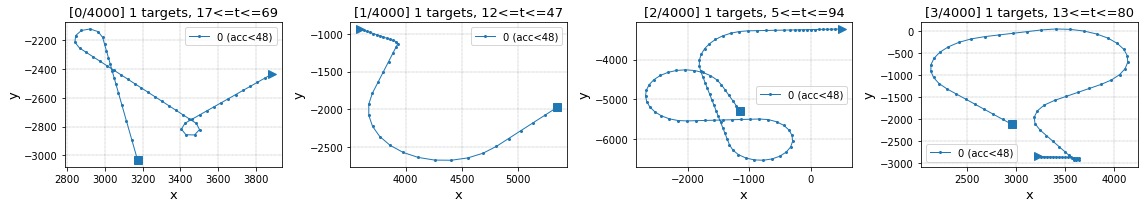

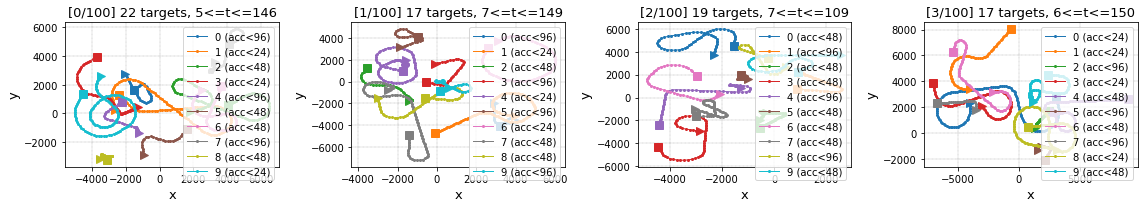

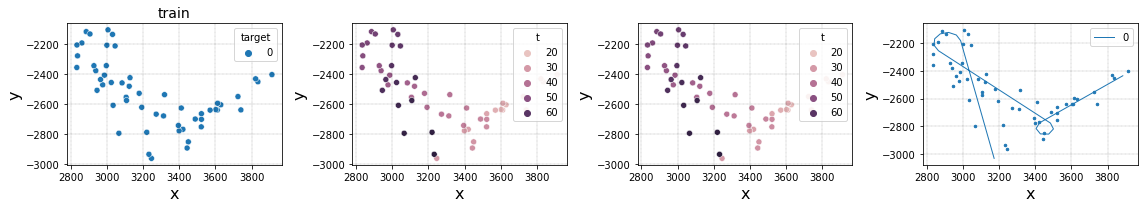

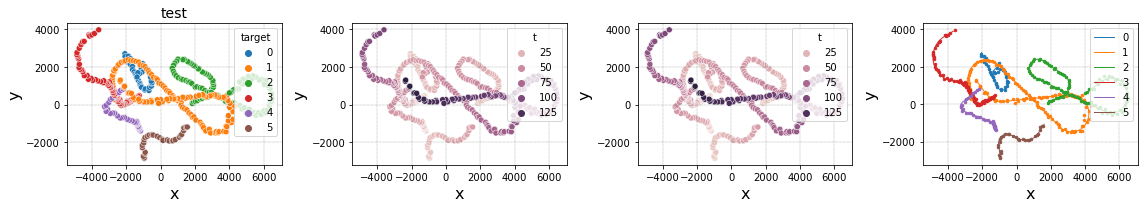

In [12]:
E.show_episodes(episodes_per_scenario=4, max_targets=10)
E.show_detections()

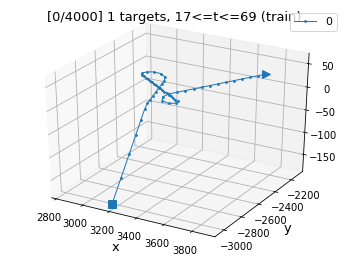

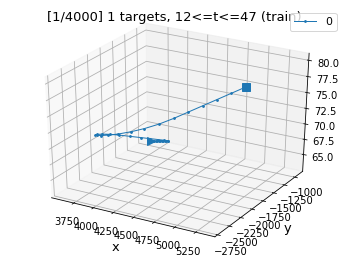

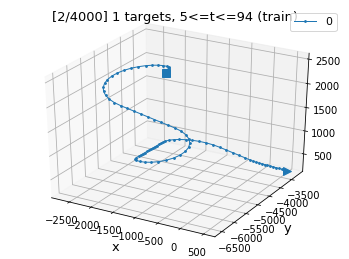

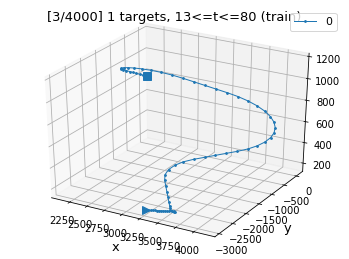

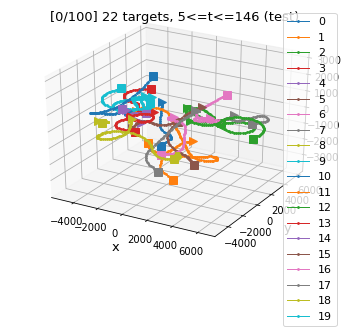

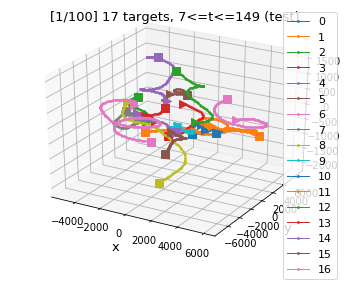

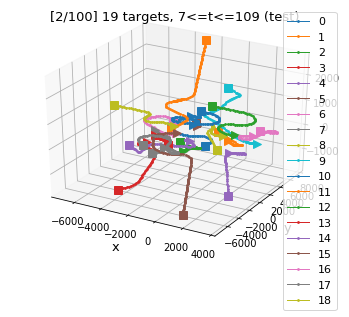

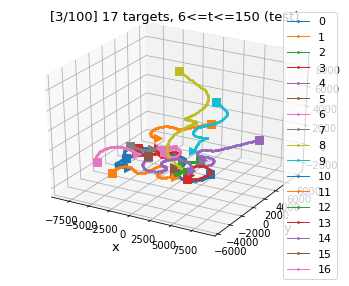

In [12]:
for sc in E.scenarios:
    Sim.show_episodes_3D(E.targets[sc], E.target_args[sc], max_episodes=4, max_targets=20, tit=sc)

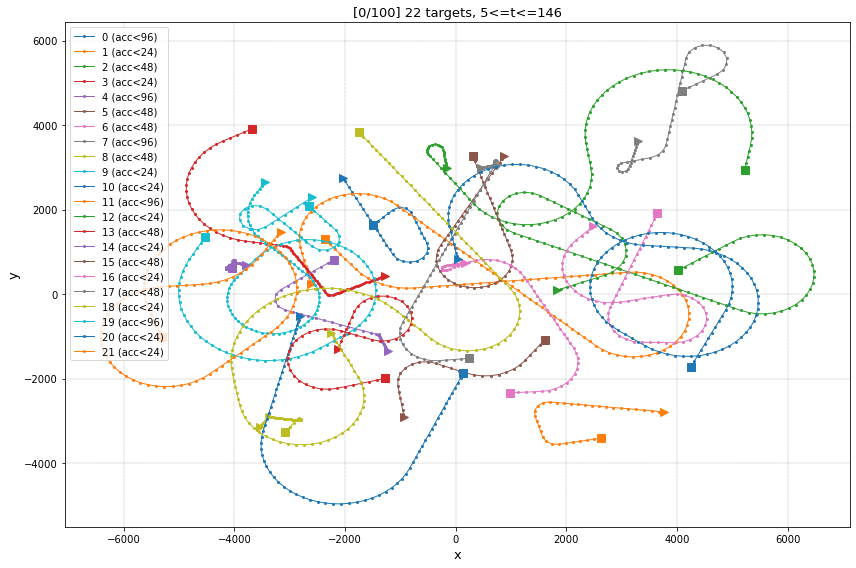

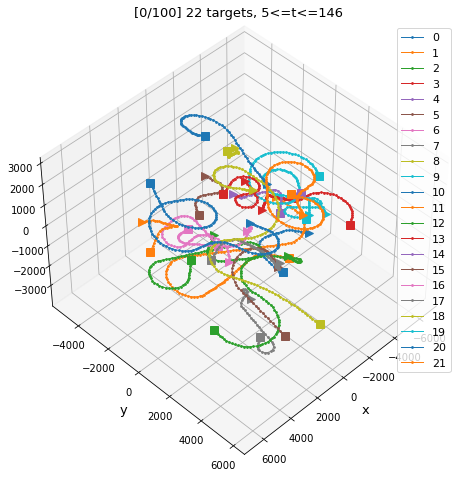

In [14]:
E.show_episodes(scenarios=['test'], episodes_per_scenario=1, max_targets=24, axs=utils.Axes(1,1,axsize=(12,8)))
axs = Sim.show_episodes_3D(E.targets['test'], E.target_args['test'], max_episodes=1, max_targets=24, figsize=(12,8))
axs[0].view_init(45, 45)

# Train models

In [48]:
models_args = [
    dict(load=False, title='KFc', no_acc=True),
    dict(load=False, title='KFp', no_acc=True, polar_R=True),
    dict(load=False, title='OKFc', no_acc=True, const_R=False, const_Q=False),
    dict(load=False, title='OKFp', no_acc=True, const_R=False, const_Q=False, polar_R=True),
    dict(load=False, title='aKFc'),
    dict(load=False, title='aKFp', polar_R=True),
    dict(load=False, title='NKFc', dynamic_Q='nn', dynamic_R=True),
    dict(load=False, title='NKFp', dynamic_Q='nn', dynamic_R=True, polar_R=True),
    dict(load=False, title='NKFHc', dynamic_Q='nn', dynamic_R=True, pred_H=1),
    dict(load=False, title='NKFHp', dynamic_Q='nn', dynamic_R=True, pred_H=1, polar_R=True),
]

gc.collect()

63762

Waiting for trainings...
Waiting for processes...
Done.	(59448 [s])
Best validation losses:
	KFc: inf (KFc_s00), inf (KFc_s01), inf (KFc_s02)
	KFp: inf (KFp_s00), inf (KFp_s02), inf (KFp_s01)
	OKFc: 111 (OKFc_s02), 111 (OKFc_s00), 111 (OKFc_s01)
	OKFp: 108 (OKFp_s01), 108 (OKFp_s02), 108 (OKFp_s00)
	aKFc: 114 (aKFc_s02), 114 (aKFc_s00), 114 (aKFc_s01)
	aKFp: 131 (aKFp_s01), 130 (aKFp_s02), 128 (aKFp_s00)
	NKFc: 112 (NKFc_s01), 112 (NKFc_s02), 111 (NKFc_s00)
	NKFp: 112 (NKFp_s01), 114 (NKFp_s00), 113 (NKFp_s02)
	NKFHc: 114 (NKFHc_s00), 114 (NKFHc_s01), 112 (NKFHc_s02)
	NKFHp: 130 (NKFHp_s00), 130 (NKFHp_s01), 130 (NKFHp_s02)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_K

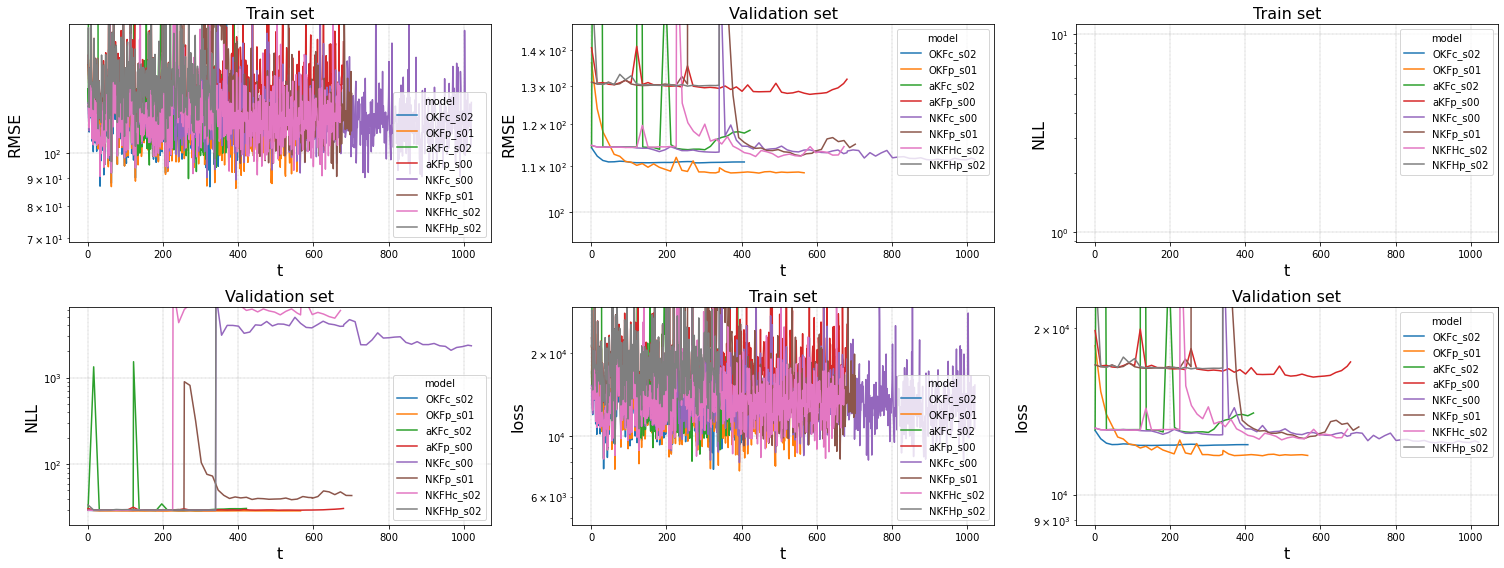

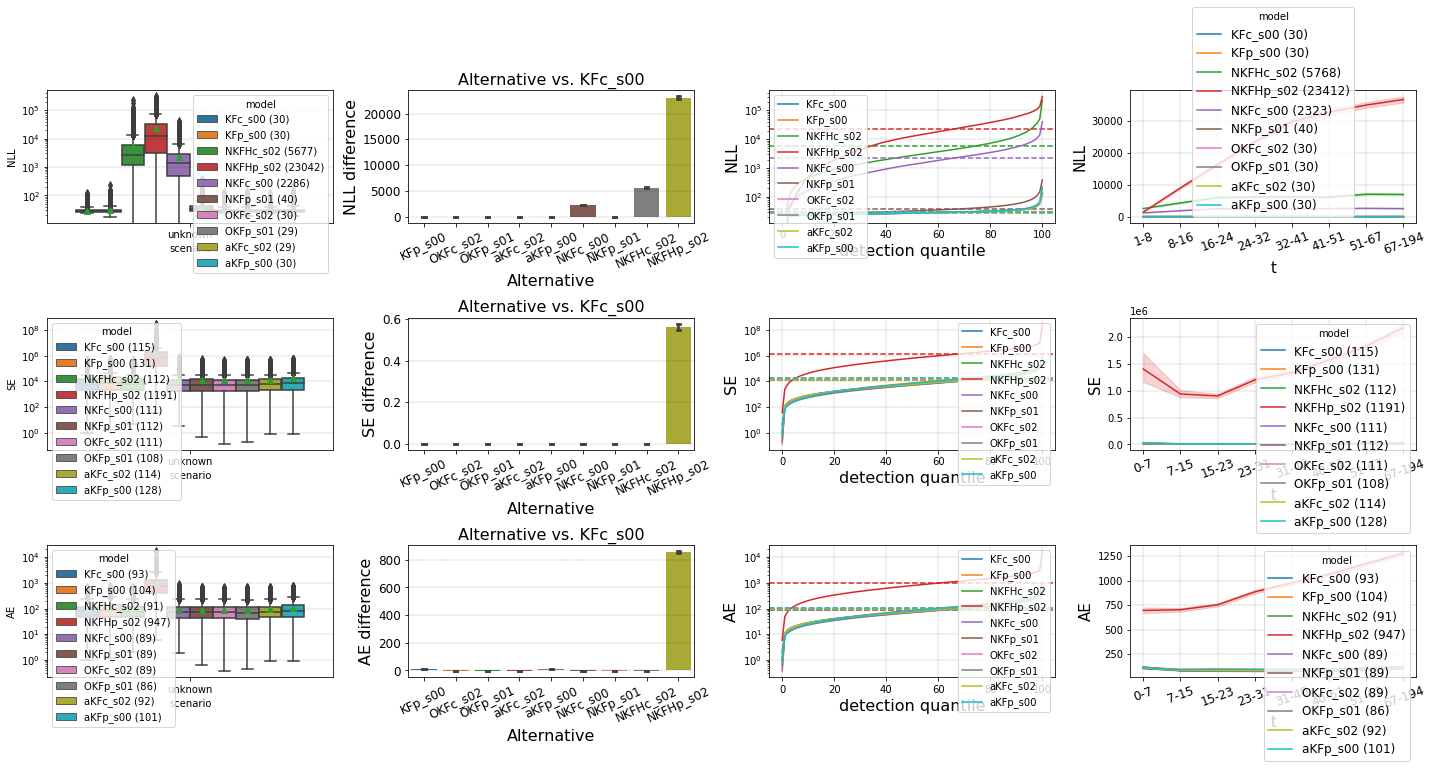

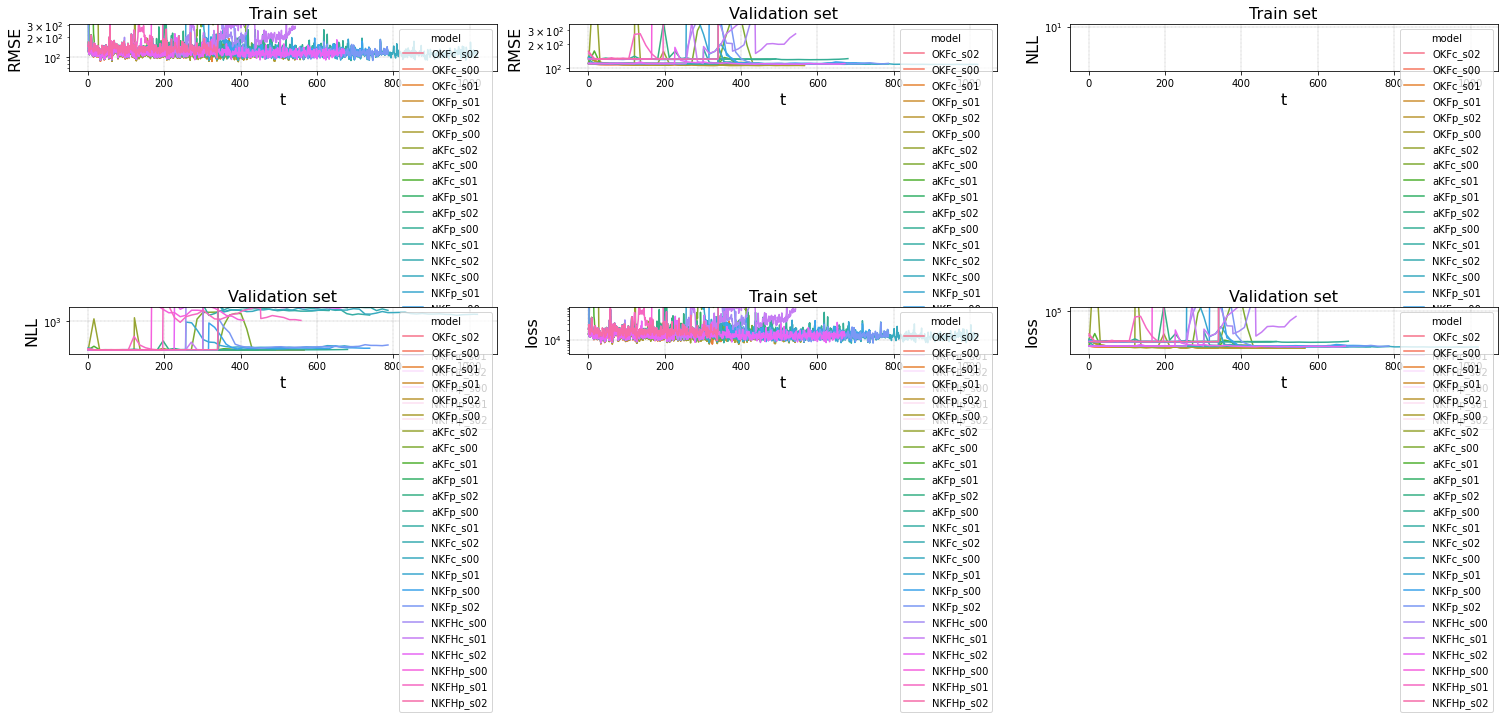

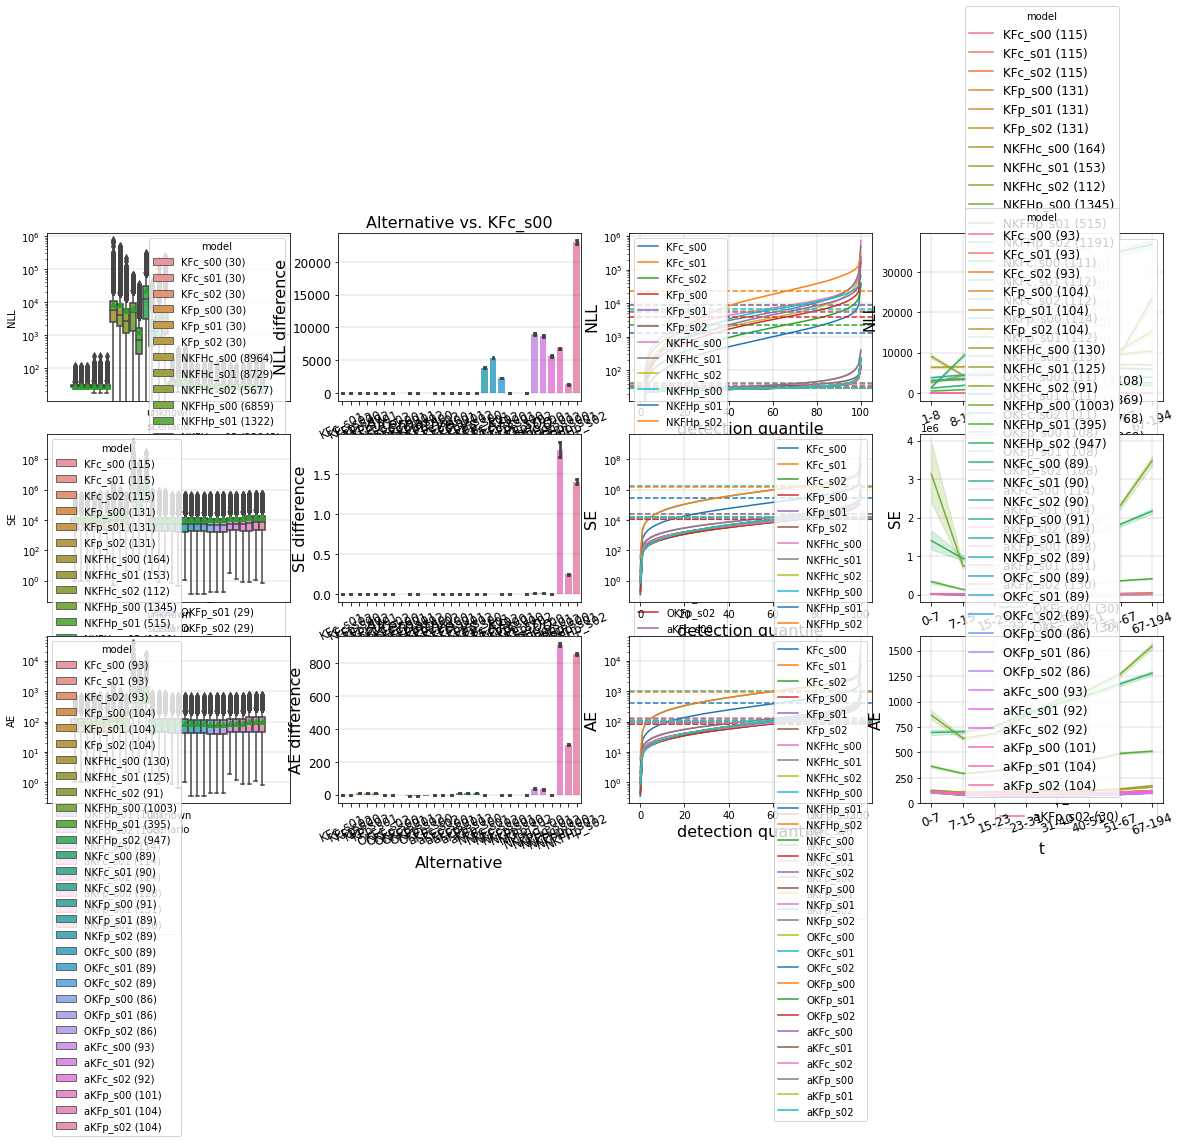

In [49]:
seeds = 3 # train each variant multiple times with different initializations (seeds), and choose the best one according to the validation data

# train
models, train_res, valid_res, ddt, ddv, losses = \
    PLAB.train_models(models_args, X, Y, seeds=seeds, save_res=f'data{ID:02d}', model_fname_prefix=f'data{ID:02d}', n_epochs=2, batch_size=20,
                      tune_phase=True, batch_fac=1, lr_fac=0.5, lr=1e-2, lr_decay=0.5, lr_decay_freq=150, verbose=2)

# show results of chosen models
PLAB.train_summary(train_res, ylim_quant=90);
PLAB.test_analysis(valid_res);

# show results of all models
if seeds > 1:
    PLAB.train_summary(ddt, ylim_quant=90);
    PLAB.test_analysis(ddv);

# Test models

In [74]:
res = PLAB.test_models(models, X2, Y2, scenarios_test)

10 models are split to 2 batches.
Running 20 threads...
Finished models-batch 1/2.	(136 [s])
Running 20 threads...
Finished models-batch 2/2.	(195 [s])


Results for all models (except for particularly bad ones, which skew the visilibity of the figures):

/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


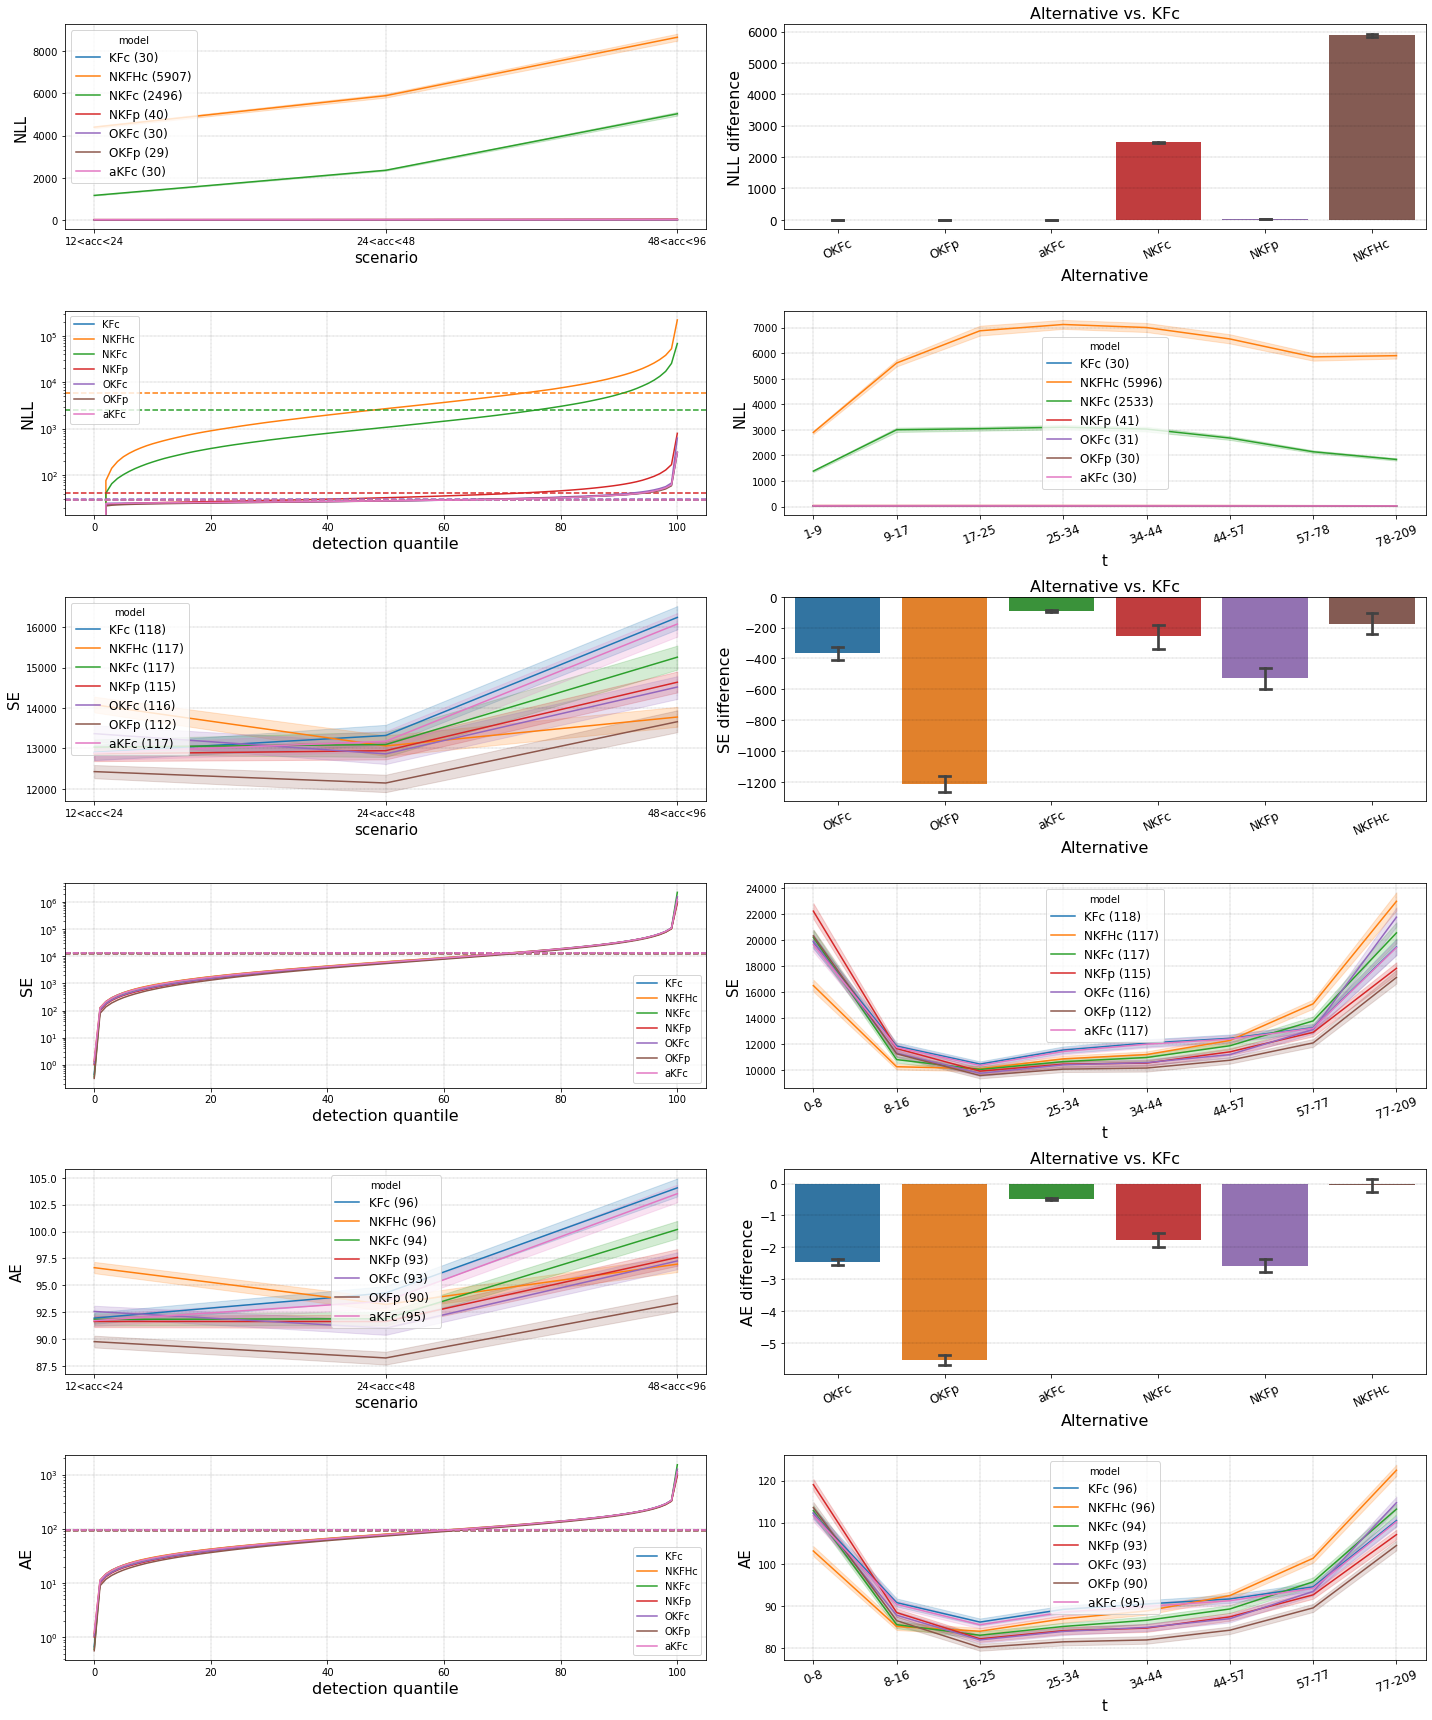

In [75]:
axs = PLAB.test_analysis(res[~res.model.isin(('KFp','aKFp','NKFHp'))], axargs=dict(W=2, axsize=(10,4)))

Results of KF,NKF,OKFp only (used for the original paper revision):

<ipython-input-52-f18be14e1105>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res2['model'] = [m[:-1] for m in res2.model]
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


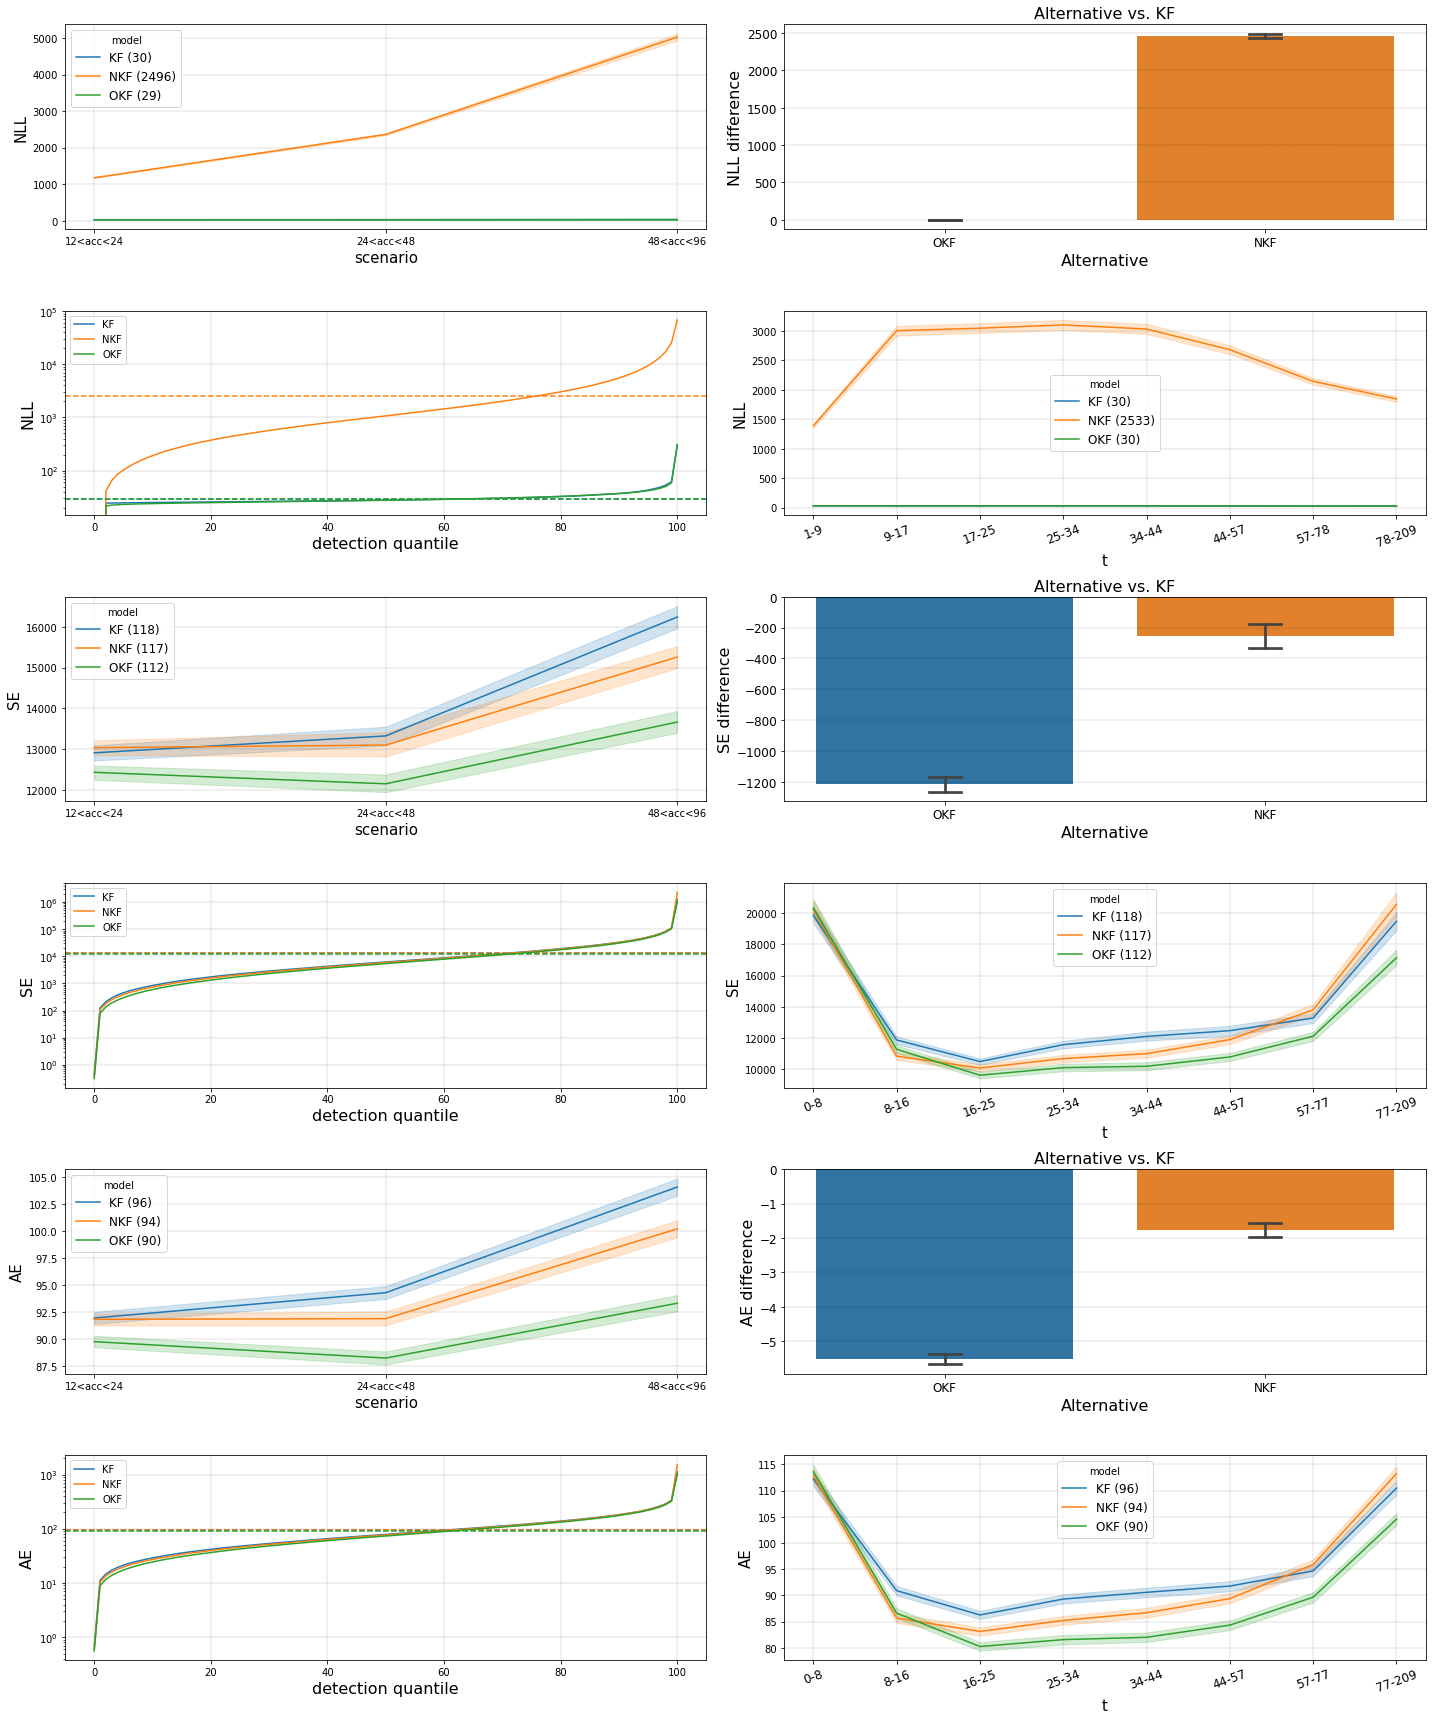

In [52]:
res2 = res[res.model.isin(('KFc','NKFc','OKFp'))]
res2['model'] = [m[:-1] for m in res2.model]
axs = PLAB.test_analysis(res2, axargs=dict(W=2, axsize=(10,4)))

#### For each model - results for the best variant among Cartesian/polar (selected using the validation data in the training summary above):

/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


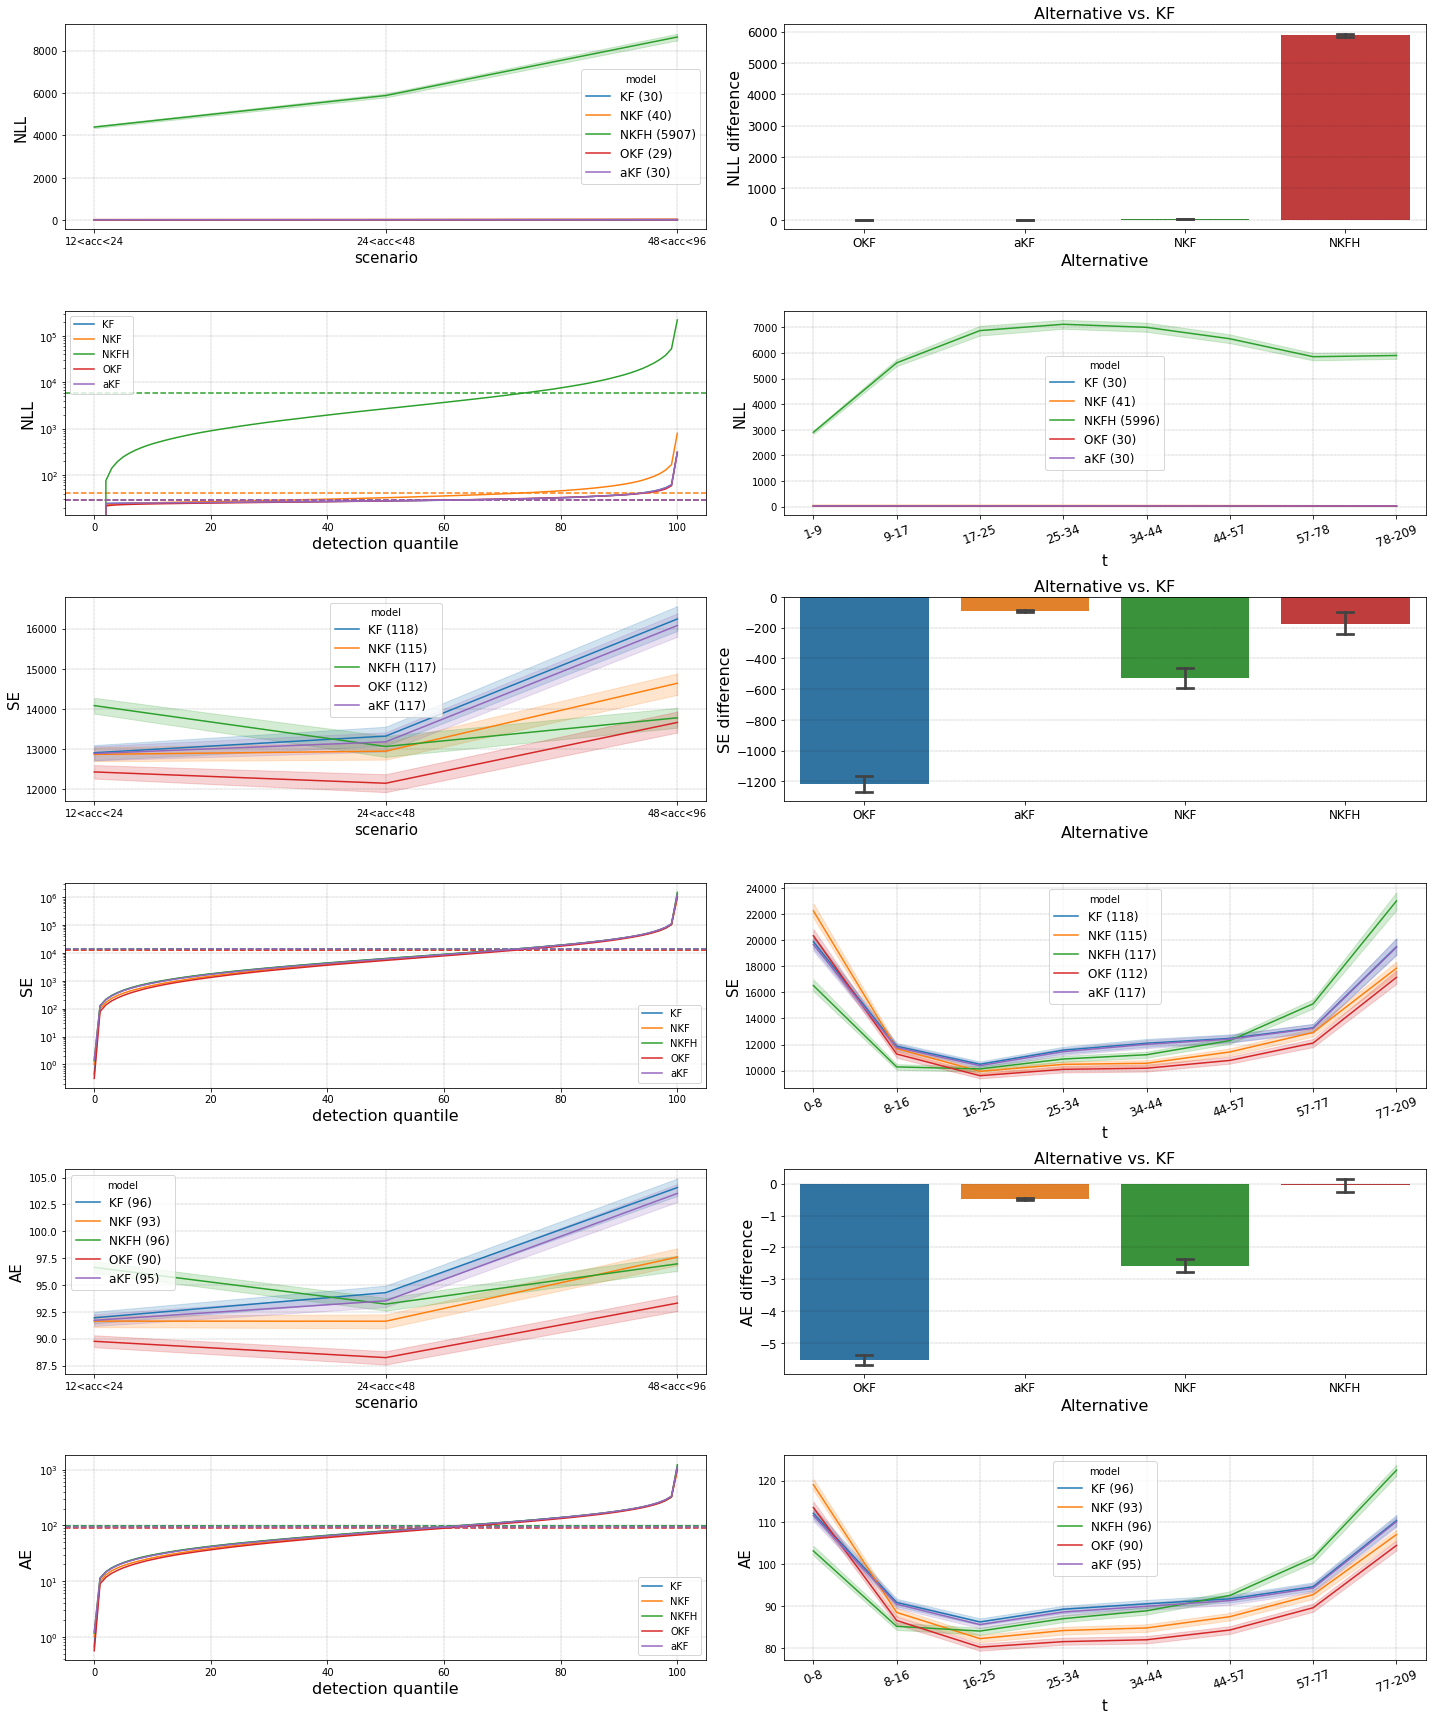

In [81]:
res2 = res[res.model.isin(('KFc','OKFp','aKFc','NKFp','NKFHc'))].copy()
res2['model'] = [m[:-1] for m in res2.model]
axs = PLAB.test_analysis(res2, axargs=dict(W=2, axsize=(10,4)))

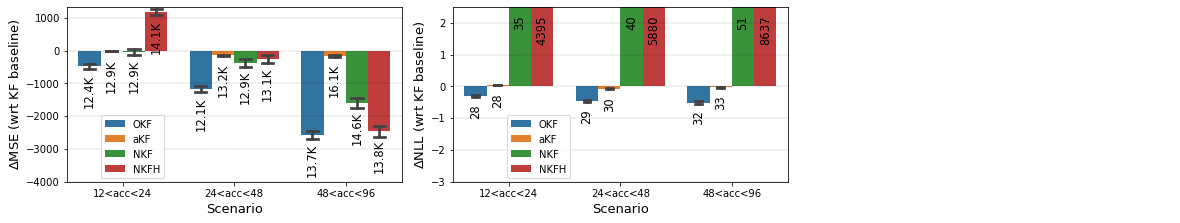

In [82]:
axs = utils.Axes(2, 3, (5.5,3.2))

res2 = res[res.model.isin(('KFc','OKFp','aKFc','NKFp','NKFHc'))].copy()
res2['model'] = [m[:-1] for m in res2.model]

res2['SE_difference'] = 0
for m in np.unique(res2.model):
    res2.loc[res2.model==m, 'SE_difference'] = res2.loc[res2.model==m, 'SE'].values - res2.loc[res2.model=='KF', 'SE'].values
ax = axs[0]
h = sns.barplot(data=res2[res2.model!='KF'], x='scenario', hue='model', y='SE_difference', ax=ax, ci=95, capsize=.1);
for i,(p,s) in enumerate(zip(h.patches, len(np.unique(res2.model))*list(np.unique(res2.scenario)))):
    lab = p.get_height() + res2.SE[(res2.model=='KF')&(res2.scenario==s)].mean()
    h.annotate(f'{lab/1000:.1f}K',
               (p.get_x() + p.get_width() / 2., p.get_height()), rotation=90,
               ha = 'center', va = 'top',  size=11.5, xytext = (0, -8),  textcoords = 'offset points')
ax.set_ylim((-4000,1330))
ax.legend(loc=(0.1,0.02))
axs.labs(0, 'Scenario', '$\Delta$MSE (wrt KF baseline)', None, fontsize=13)

res2['NLL_difference'] = 0
for m in np.unique(res2.model):
    res2.loc[res2.model==m, 'NLL_difference'] = res2.loc[res2.model==m, 'NLL'].values - res2.loc[res2.model=='KF', 'NLL'].values
ax = axs[1]
h = sns.barplot(data=res2[res2.model!='KF'], x='scenario', hue='model', y='NLL_difference', ax=ax, ci=95, capsize=.06);
ymax = 2.5
for i,(p,s) in enumerate(zip(h.patches, len(np.unique(res2.model))*list(np.unique(res2.scenario)))):
    lab = p.get_height() + res2.NLL[(res2.model=='KF')&(res2.scenario==s)].mean()
    h.annotate(f'{lab:.0f}',
               (p.get_x() + p.get_width() / 2., min(p.get_height(),ymax)), rotation=90,
               ha = 'center', va = 'top',  size=11.5, xytext = (0, -8),  textcoords = 'offset points')
ax.set_ylim((-3,ymax))
ax.legend(loc=(0.16,0.02))
axs.labs(1, 'Scenario', '$\Delta$NLL (wrt KF baseline)', None, fontsize=13)

plt.tight_layout();
plt.savefig('outputs/NKF_Free_paired_res.png', bbox_inches='tight');

TODO display results over a sample of targets (plot trajectories or show likelihood-colormap).

# Test models in complete tracking task

In [76]:
title=f'benchmark{ID:02d}'
E = PLAB.create_experiment(title=title, load=True)

In [77]:
tracker_args = [
    dict(load=False, title='KFc', no_acc=True),
    dict(load=False, title='OKFp', no_acc=True, const_R=False, const_Q=False, polar_R=True),
    dict(load=False, title='NKFc', dynamic_Q='nn', dynamic_R=True),
]

for i in range(len(tracker_args)):
    tracker_args[i]['load'] = f"data{ID:02d}_{tracker_args[i]['title']}"

E.solvers_args = {}
E.solvers_args['Naive'] = ((Trackers.HungarianAssigner,{}), (Trackers.NaiveTracker, dict()))
for args in tracker_args:
    E.solvers_args[args['title']] = ((Trackers.HungarianAssigner,dict(match_thresh=np.inf)), (NT.NeuralKF, args))

E.initialize_solvers()

In [78]:
SAVE_RES = f'benchmark{ID:02d}_res'
E.run_scenarios(group=1, do_save=SAVE_RES, distributed=True, gb_per_job=4)

Running train...
Reduced distribution to 5 cores to fit into 29GB.
 done.	(0 [s])
Running test...
Reduced distribution to 5 cores to fit into 28GB.
	Batch 0 starts...
	Batch 1 starts...
	Batch 2 starts...
	Batch 3 starts...
	Batch 4 starts...
		[01/05] episode 005/020 done.	(127.7 [s])
		[00/05] episode 005/020 done.	(131.2 [s])
		[02/05] episode 005/020 done.	(126.2 [s])
		[04/05] episode 005/020 done.	(133.7 [s])
		[03/05] episode 005/020 done.	(138.5 [s])
		[03/05] episode 010/020 done.	(265.6 [s])
		[01/05] episode 010/020 done.	(273.2 [s])
		[00/05] episode 010/020 done.	(286.2 [s])
		[02/05] episode 010/020 done.	(292.1 [s])
		[04/05] episode 010/020 done.	(295.6 [s])
		[01/05] episode 015/020 done.	(401.6 [s])
		[03/05] episode 015/020 done.	(404.3 [s])
		[00/05] episode 015/020 done.	(430.0 [s])
		[02/05] episode 015/020 done.	(426.9 [s])
		[04/05] episode 015/020 done.	(435.1 [s])
	Batch 1 done.	(545.3 [s])
	Batch 0 done.	(560.7 [s])
	Batch 3 done.	(559.3 [s])
	Batch 4 done.	(

Scenarios: ['test']


/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarni

   phase      mode  time        acc   direct       angle
0      0  straight     6  75.042747  forward    0.000000
1      1      turn     4  16.094150     down  -20.581769
2      2  straight     6  59.927732  forward    0.000000
3      3      turn     8  49.299850     left -136.521071
4      4  straight     6  80.937744  forward    0.000000
5      5      turn     3  85.172373     left  -90.698091
6      6  straight     4  83.739090  forward    0.000000


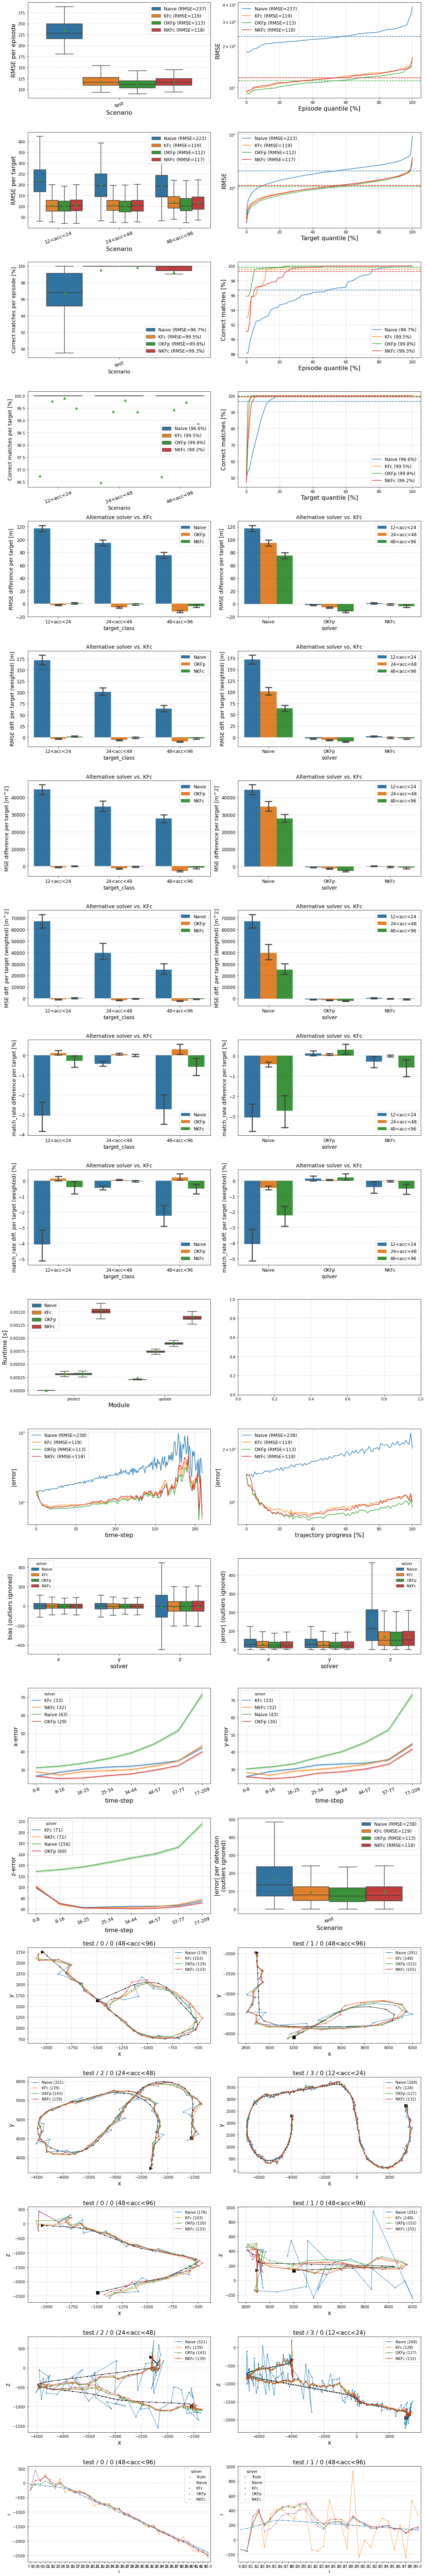

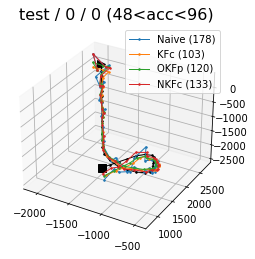

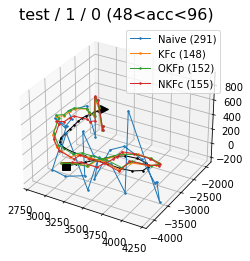

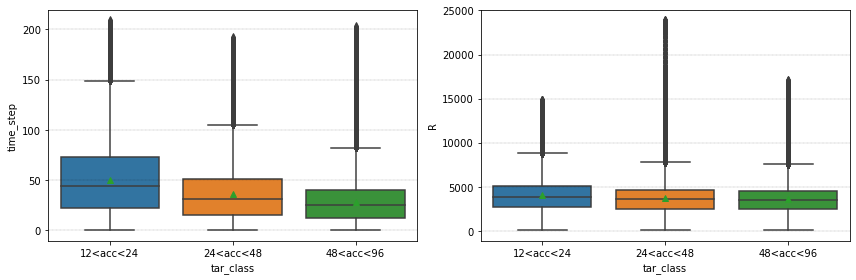

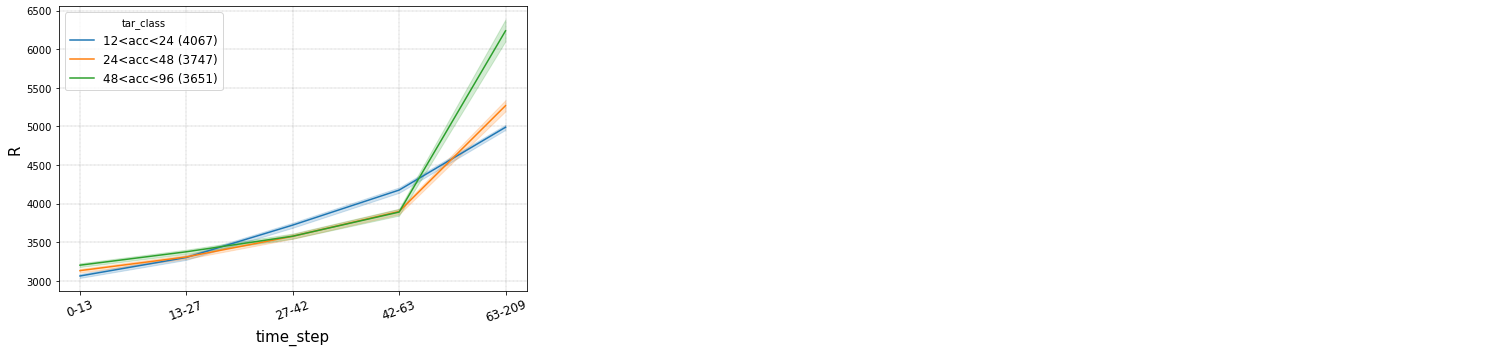

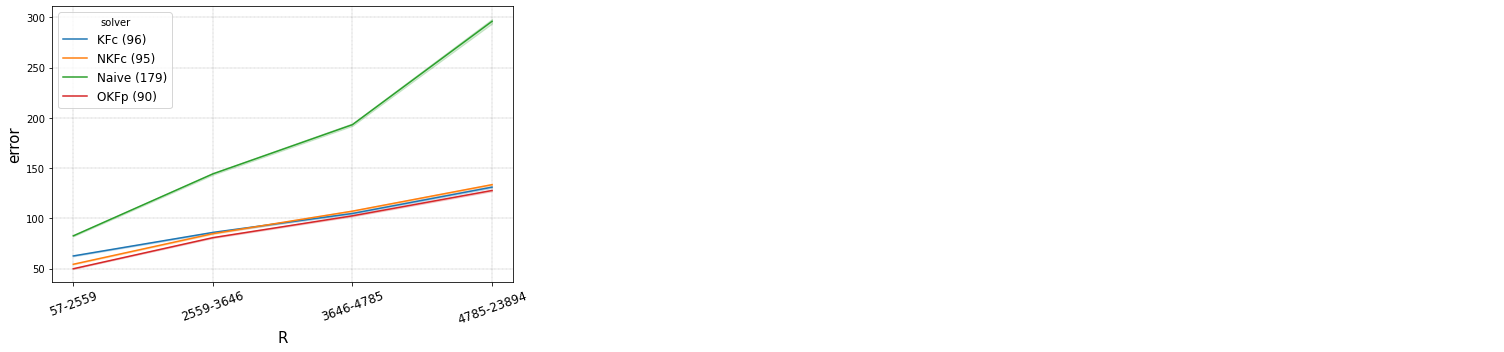

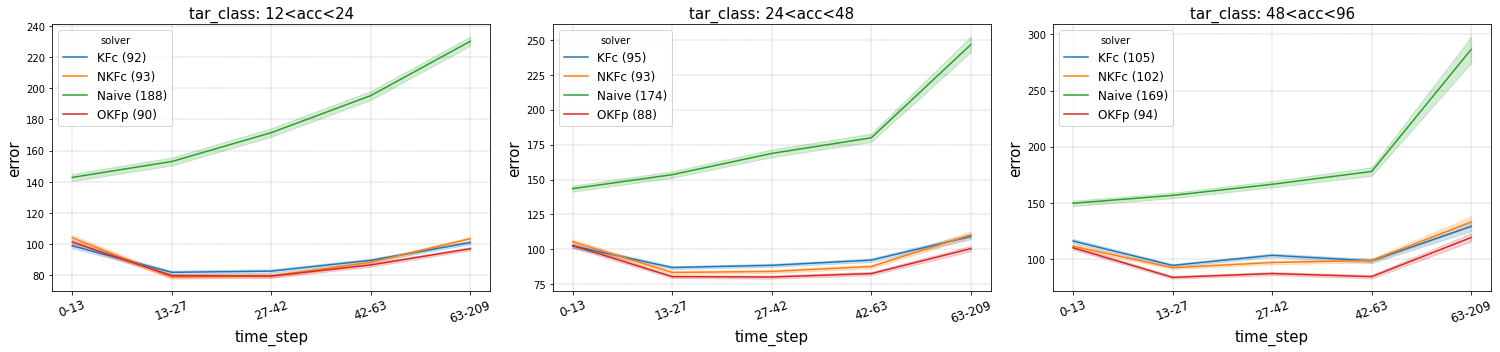

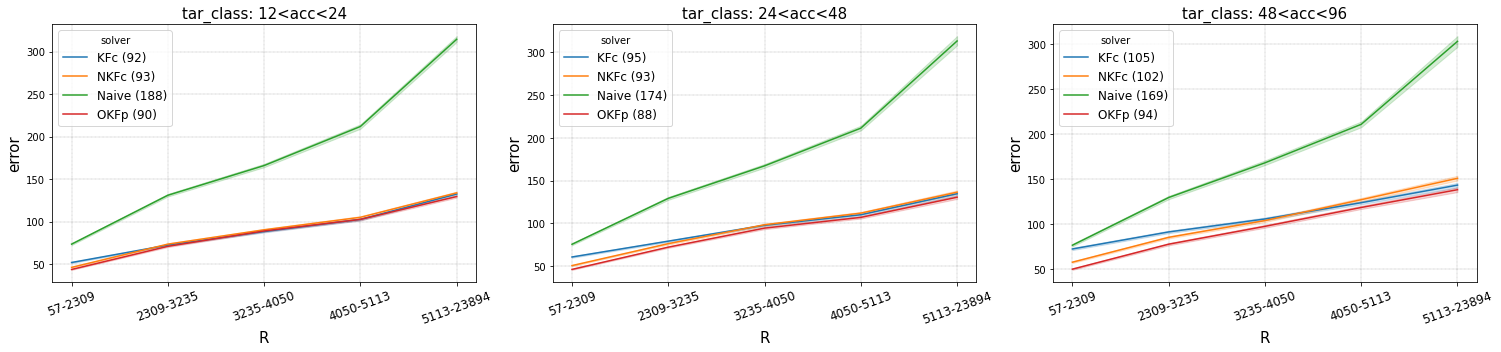

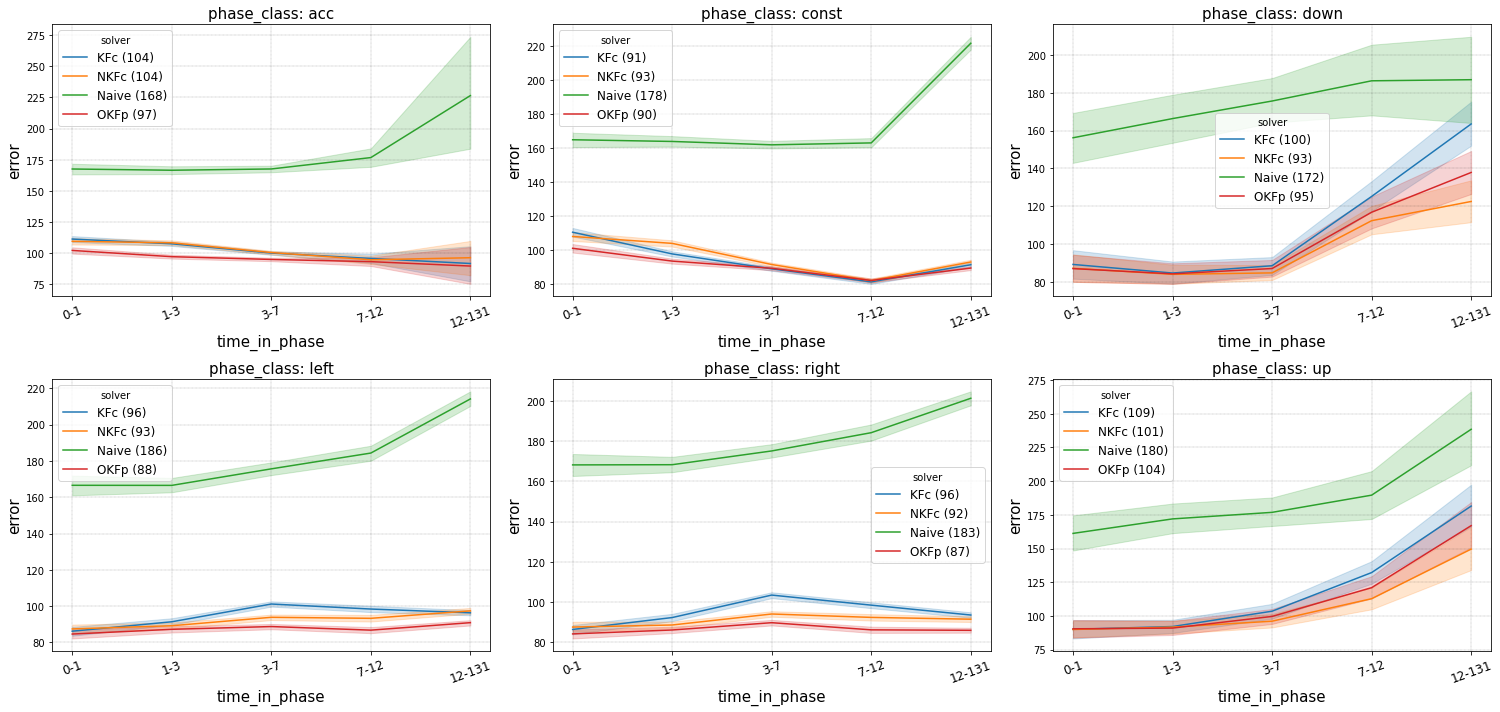

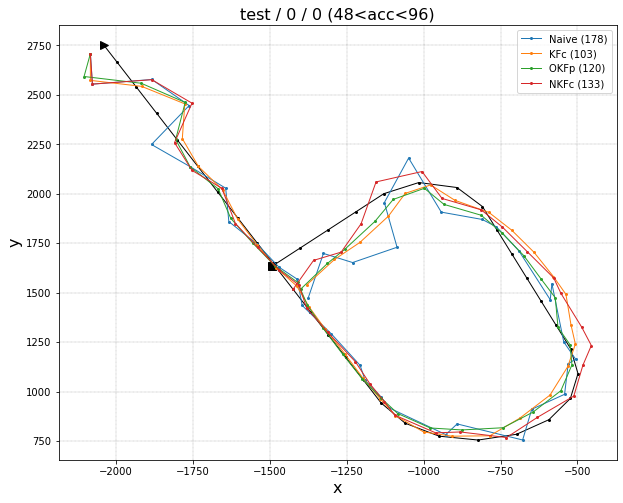

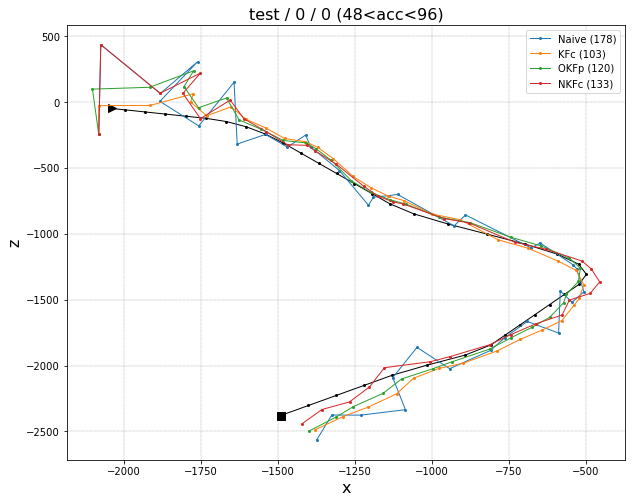

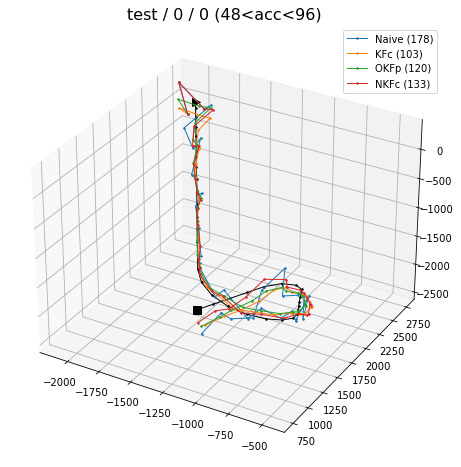

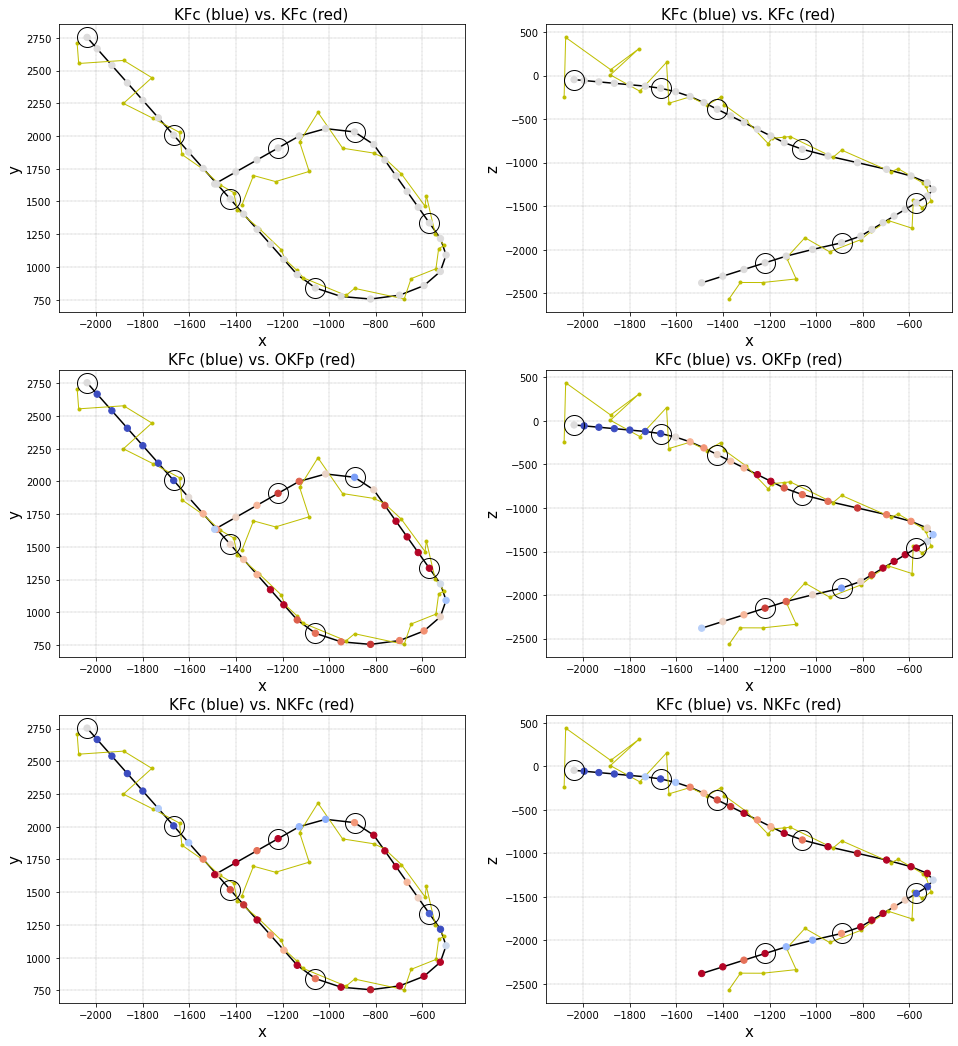

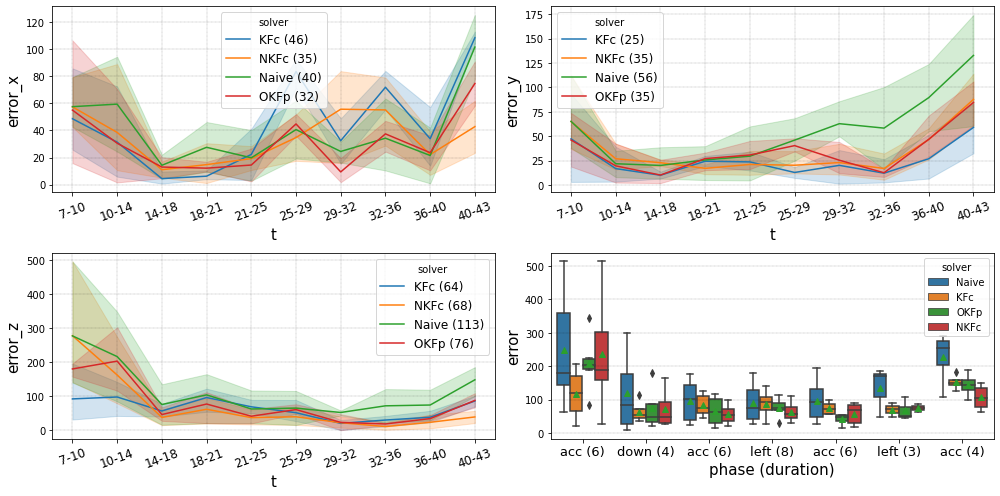

In [79]:
E.analyze_results(scenarios=['test'], ref_solver='KFc', large=1); # group=1

**Errors correlation**: the correlations between the signed-errors of OKF_p & NKF (i.e. E.res.bias_x/y/z) are 83-4% for x,y dimensions and 93% for z.
When using the simple average of the two (which would be quite a computational overkill), the RMSE is only slightly reduced compared to OKF_p - by around 30% of the original difference between OKF_p & NKF.

   phase      mode  time        acc   direct      angle
0      0  straight    17   0.000000  forward   0.000000
1      1      turn     2  49.507299    right  95.351834
2      2  straight     4  84.644238  forward   0.000000
3      3      turn     4  56.900689    right  76.356460
4      4  straight     4  72.148707  forward   0.000000
5      5      turn     4  17.702421     down -26.210674
6      6  straight     4  94.957482  forward   0.000000


[<utils.Axes at 0x7fada68098b0>, <utils.Axes at 0x7fada69644c0>]

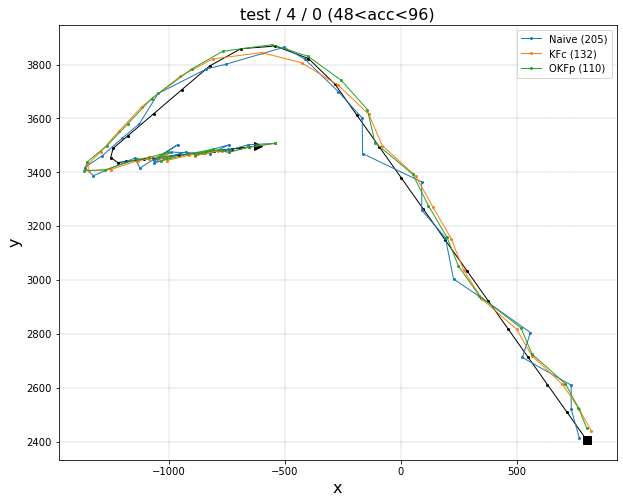

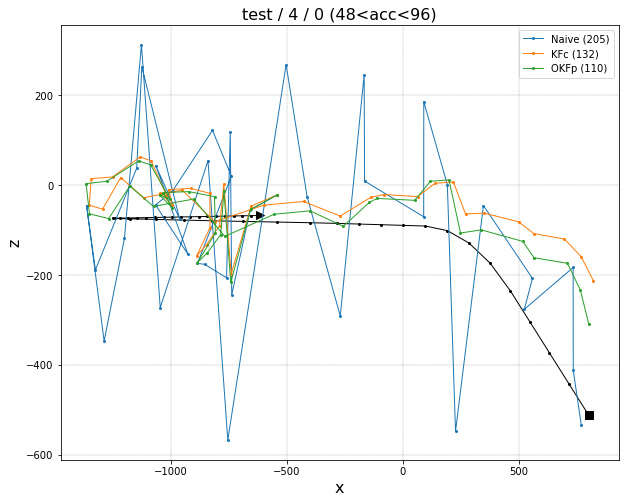

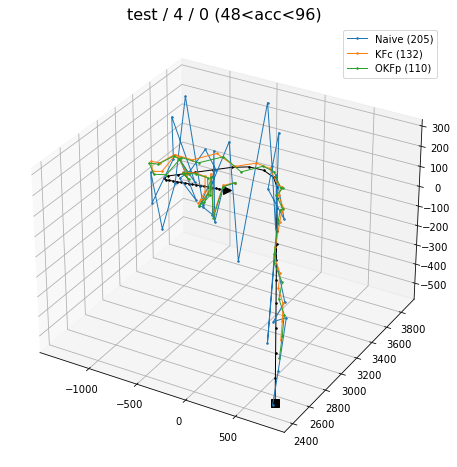

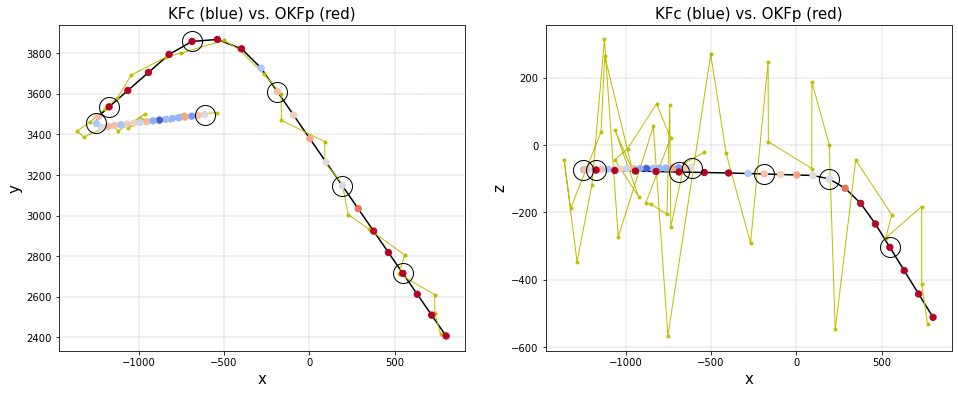

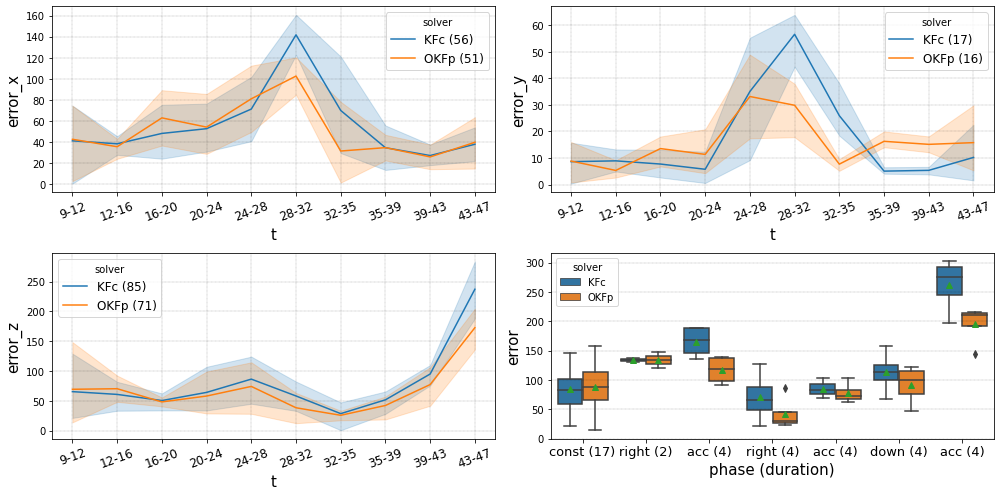

In [80]:
E.target_analysis('test',4,0, solvers=['KFc','OKFp'])

In [26]:
# ax = E.plot_trajectories_3d(['test'],[2],[3], solvers=['KF','OKF_p','NKF'], figsize=(12,12))[0]
# ax.view_init(30, 45)

# plt.figure()
# for col in ('Naive', 'KF','OKF_p','NKF'):
#     plt.plot(np.sqrt(E.targets['test'][2][3][f'SE_{col}']), label=col)
# plt.grid()
# plt.xlabel('time')
# plt.ylabel('square error')
# plt.legend();

In [27]:
# axs = E.plot_trajectories_3d(scenarios=('acc32',), episodes=[0], targets=[0], n_targets=1, figsize=(12,10), solvers=['Naive','KF','OKF_p','NKF'])
# axs[0].set_xlim((-500,0))
# axs[0].set_ylim((-50,900))
# axs[0].set_zlim((-100,0))
# axs[0].view_init(20, 90)